In [11]:
import time
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from evosax import CMA_ES, SimAnneal

from envs.single_photon_env import SinglePhotonLangevinReadoutEnv

In [10]:
seed = 30

In [47]:
# Defining Cairo Params and RL Params

tau_0 = 0.398
kappa = 20.0
chi = 0.65 * 2. * jnp.pi
kerr = 0.002
gamma = 1/140
time_coeff = 10.0
snr_coeff = 10.0
smoothness_coeff = 10.0
n0 = 43
res_amp_scaling = 1/0.43
actual_max_photons = n0 * (1 - jnp.exp(-0.5 * kappa * tau_0))**2
print(f"Rough Max Photons: {n0}")
print(f"Actual Max Photons: {actual_max_photons}")
nR = 0.01
snr_scale_factor = 1.9
gamma_I = 1/140
num_t1 = 5.0
photon_gamma = 1/1500
init_fid = 1 - 1e-4
photon_weight = 4.0

num_envs = 512
num_updates = 2000
config = {
    "LR": 3e-3,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": 1,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu6",
    "LAYER_SIZE": 64,
    "ENV_NAME": "photon_langevin_readout_env",
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 43
Actual Max Photons: 41.40804860100575


In [48]:
env = SinglePhotonLangevinReadoutEnv(
    kappa=kappa,
    chi=chi,
    kerr=kerr,
    time_coeff=time_coeff,
    snr_coeff=snr_coeff,
    smoothness_coeff=smoothness_coeff,
    n0=n0,
    tau_0=tau_0,
    res_amp_scaling=res_amp_scaling,
    nR=nR,
    snr_scale_factor=snr_scale_factor,
    gamma_I=gamma_I,
    photon_gamma=photon_gamma,
    num_t1=num_t1,
    init_fid=init_fid,
    photon_weight=photon_weight,
)

In [49]:
# Instantiate the search strategy

cma_strategy = CMA_ES(popsize=num_envs, num_dims=env.num_actions, elite_ratio=0.6)
cma_params = cma_strategy.default_params.replace(
    init_min=-1, 
    init_max=1,
    clip_min=-env.mu,
    clip_max=env.mu)
cma_params

EvoParams(mu_eff=Array(126.59649826, dtype=float64), c_1=Array(0.00013259, dtype=float64), c_mu=Array(0.01633557, dtype=float64), c_sigma=Array(0.5090985, dtype=float64), d_sigma=Array(1.53836388, dtype=float64), c_c=Array(0.03970535, dtype=float64), chi_n=Array(10.9773085, dtype=float64, weak_type=True), c_m=1.0, sigma_init=1.0, init_min=-1, init_max=1, clip_min=-2.3255813953488373, clip_max=2.3255813953488373)

In [50]:
# Simulated Annealing

sim_anneal = SimAnneal(popsize=num_envs, num_dims=env.num_actions)
sim_params = sim_anneal.default_params
sim_params = sim_params.replace(
    init_min=-1, 
    init_max=1,
    clip_min=-env.mu,
    clip_max=env.mu,)

In [51]:
def single_rollout(action):
    smooth_drive = env.prepare_action(action)

    single_res = env.calc_results(smooth_drive)
    reward, _state = env.calc_reward_and_state(
        single_res.astype(env.float_dtype), smooth_drive
    )

    fitness = -reward # Since we are dealing with minimisation

    return fitness.astype(jnp.float32), _state

vmap_rollout = jax.jit(jax.vmap(single_rollout))

## CMA-ES Training

In [55]:
rng = jax.random.PRNGKey(seed)

sim_name = 'CMA_ES'

# Make the Jax Random Seed in the Training Cell
# To ensure same seed is used for all runs
rng = jax.random.PRNGKey(seed=seed)
rng, _rng = jax.random.split(rng)

cma_state = cma_strategy.initialize(_rng, cma_params)

start = time.time()

# For Logging
print_rate = 100 # For monitoring the learning
total_train_gens = 5_000

def_reward = 100.
cma_fitness_arr = np.zeros(total_train_gens) - def_reward
cma_rewards_arr = np.zeros((total_train_gens, num_envs))
cma_smoothness_arr = np.zeros((total_train_gens, num_envs))
cma_photon_time_arr = np.zeros((total_train_gens, num_envs))
cma_pF_arr = np.zeros((total_train_gens, num_envs))
cma_actions_arr = np.zeros((total_train_gens, env.num_actions))

# Run ask-eval-tell loop - NOTE: By default minimization
for t in range(total_train_gens):
    rng, rng_gen = jax.random.split(rng, 2)
    x, cma_state = cma_strategy.ask(rng_gen, cma_state, cma_params) # Sampling actions from strategy
    fitness, env_state = vmap_rollout(x) # Function we defined
    cma_state = cma_strategy.tell(x, fitness, cma_state, cma_params) # Updating strategy with fitnesses

    # Logging
    cma_fitness_arr[t] = jnp.mean(fitness)
    cma_actions_arr[t] = jnp.mean(x, axis=0)

    cma_rewards_arr[t] = env_state[:,0]
    cma_pF_arr[t] = env_state[:,1]
    cma_photon_time_arr[t] = env_state[:,3]
    cma_smoothness_arr[t] = env_state[:,4]

    if (t + 1) % print_rate == 0:
        print(f"{cma_name} - # Gen: {t + 1}|Fitness: {cma_state.best_fitness}")
        print(f"Reward: {jnp.round(jnp.mean(cma_rewards_arr[t]), 2)} ± {jnp.round(jnp.std(cma_rewards_arr[t]), 2)}")
        print(f"pF: {jnp.round(jnp.mean(cma_pF_arr[t]), 3)} ± {jnp.round(jnp.std(cma_pF_arr[t]), 3)}")
        print(f"Photon Time: {jnp.round(jnp.mean(cma_photon_time_arr[t]), 4)} ± {jnp.round(jnp.std(cma_photon_time_arr[t]), 4)}")
        print(f"Smoothness: {jnp.round(jnp.mean(cma_smoothness_arr[t]), 6)} ± {jnp.round(jnp.std(cma_smoothness_arr[t]), 6)}")
        print(f"Time: {time.time() - start}")

CMA_ES - # Gen: 100|Fitness: -17.908775329589844
Reward: 15.97 ± 1.34
pF: 2.511 ± 0.025
Photon Time: 0.7439 ± 0.036000000000000004
Smoothness: 0.000252 ± 3.9999999999999996e-05
Time: 12.379026174545288
CMA_ES - # Gen: 200|Fitness: -22.97540283203125
Reward: 21.400000000000002 ± 0.8
pF: 2.5540000000000003 ± 0.005
Photon Time: 0.31170000000000003 ± 0.0674
Smoothness: 0.000178 ± 2.4999999999999998e-05
Time: 28.732884168624878
CMA_ES - # Gen: 300|Fitness: -23.165302276611328
Reward: 22.7 ± 0.51
pF: 2.563 ± 0.0
Photon Time: 0.24960000000000002 ± 0.0057
Smoothness: 0.00016199999999999998 ± 1.3e-05
Time: 42.991475105285645
CMA_ES - # Gen: 400|Fitness: -23.18574333190918
Reward: 22.89 ± 0.51
pF: 2.565 ± 0.0
Photon Time: 0.2466 ± 0.0008
Smoothness: 0.000169 ± 7e-06
Time: 54.723286867141724
CMA_ES - # Gen: 500|Fitness: -23.2073917388916
Reward: 22.89 ± 0.56
pF: 2.566 ± 0.0
Photon Time: 0.2464 ± 0.0007
Smoothness: 0.000216 ± 1.2e-05
Time: 66.35752487182617
CMA_ES - # Gen: 600|Fitness: -23.2280864

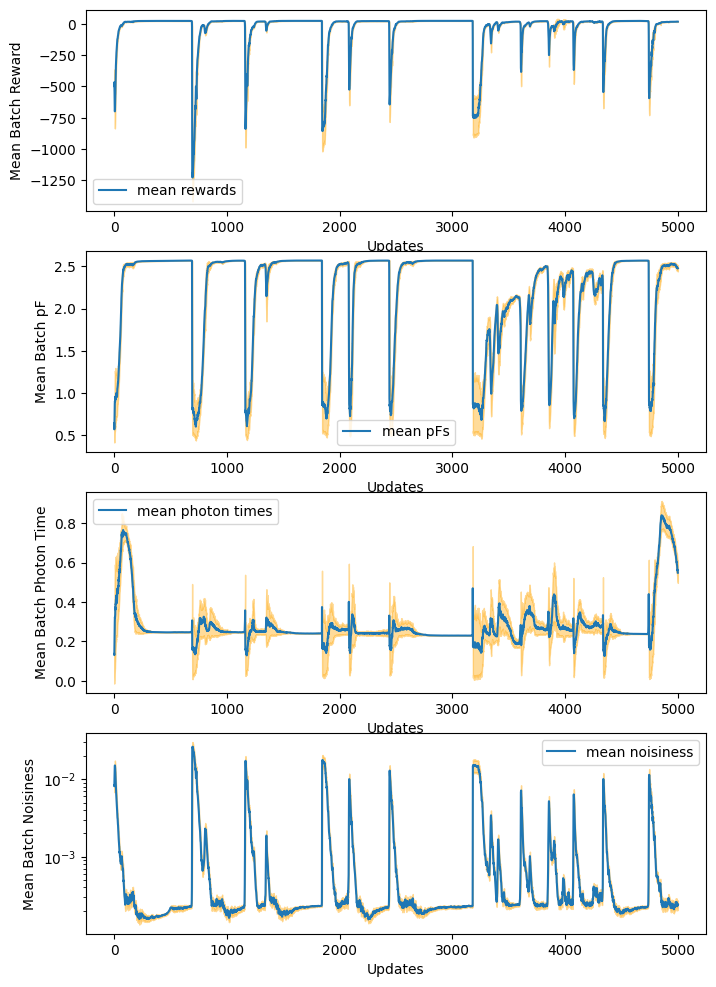

In [57]:
mean_rewards_cma = jnp.mean(cma_rewards_arr, axis=-1)
std_rewards_cma = jnp.std(cma_rewards_arr, axis=-1)

mean_pFs_cma = jnp.mean(cma_pF_arr, axis=-1)
std_pFs_cma = jnp.std(cma_pF_arr, axis=-1)

mean_times_cma = jnp.mean(cma_photon_time_arr, axis=-1)
std_times_cma = jnp.std(cma_photon_time_arr, axis=-1)

mean_smoothnesses_cma = jnp.mean(cma_smoothness_arr, axis=-1)
std_smoothnesses_cma = jnp.std(cma_smoothness_arr, axis=-1)

fig, ax = plt.subplots(4, figsize=(8.0, 12.0))

ax[0].plot(mean_rewards_cma, label='mean rewards')
ax[0].fill_between(jnp.arange(total_train_gens), mean_rewards_cma - std_rewards_cma, mean_rewards_cma + std_rewards_cma, color='orange', alpha=0.4)
ax[0].set_xlabel('Updates')
ax[0].set_ylabel('Mean Batch Reward')
ax[0].legend()

ax[1].plot(mean_pFs_cma, label='mean pFs')
ax[1].fill_between(jnp.arange(total_train_gens), mean_pFs_cma - std_pFs_cma, mean_pFs_cma + std_pFs_cma, color='orange', alpha=0.4)
ax[1].set_xlabel('Updates')
ax[1].set_ylabel('Mean Batch pF')
ax[1].legend()

ax[2].plot(mean_times_cma, label='mean photon times')
ax[2].fill_between(jnp.arange(total_train_gens), mean_times_cma - std_times_cma, mean_times_cma + std_times_cma, color='orange', alpha=0.4)
ax[2].set_xlabel('Updates')
ax[2].set_ylabel('Mean Batch Photon Time')
ax[2].legend()

ax[3].plot(mean_smoothnesses_cma, label='mean noisiness')
ax[3].fill_between(jnp.arange(total_train_gens), mean_smoothnesses_cma - std_smoothnesses_cma, mean_smoothnesses_cma + std_smoothnesses_cma, color='orange', alpha=0.4)
ax[3].set_xlabel('Updates')
ax[3].set_ylabel('Mean Batch Noisiness')
ax[3].set_yscale('log')
ax[3].legend()

plt.show()

## Simulated Annealing

In [65]:
rng = jax.random.PRNGKey(seed)

sim_name = 'SIM_ANNEAL'

# Make the Jax Random Seed in the Training Cell
# To ensure same seed is used for all runs
rng = jax.random.PRNGKey(seed=seed)
rng, _rng = jax.random.split(rng)

sim_state = sim_anneal.initialize(_rng, sim_params)

start = time.time()

# For Logging
print_rate = 100 # For monitoring the learning
total_train_gens = 20_000

def_reward = 100.
sim_fitness_arr = np.zeros(total_train_gens) - def_reward
sim_rewards_arr = np.zeros((total_train_gens, num_envs))
sim_smoothness_arr = np.zeros((total_train_gens, num_envs))
sim_photon_time_arr = np.zeros((total_train_gens, num_envs))
sim_pF_arr = np.zeros((total_train_gens, num_envs))
sim_actions_arr = np.zeros((total_train_gens, env.num_actions))

# Run ask-eval-tell loop - NOTE: By default minimization
for t in range(total_train_gens):
    rng, rng_gen = jax.random.split(rng, 2)
    x, sim_state = sim_anneal.ask(rng_gen, sim_state, sim_params) # Sampling actions from strategy
    fitness, env_state = vmap_rollout(x) # Function we defined
    sim_state = sim_anneal.tell(x, fitness, sim_state, sim_params) # Updating strategy with fitnesses

    # Logging
    sim_fitness_arr[t] = jnp.mean(fitness)
    sim_actions_arr[t] = jnp.mean(x, axis=0)

    sim_rewards_arr[t] = env_state[:,0]
    sim_pF_arr[t] = env_state[:,1]
    sim_photon_time_arr[t] = env_state[:,3]
    sim_smoothness_arr[t] = env_state[:,4]

    if (t + 1) % print_rate == 0:
        print(f"{sim_name} - # Gen: {t + 1}|Fitness: {sim_state.best_fitness}")
        print(f"Reward: {jnp.round(jnp.mean(sim_rewards_arr[t]), 2)} ± {jnp.round(jnp.std(sim_rewards_arr[t]), 2)}")
        print(f"pF: {jnp.round(jnp.mean(sim_pF_arr[t]), 3)} ± {jnp.round(jnp.std(sim_pF_arr[t]), 3)}")
        print(f"Photon Time: {jnp.round(jnp.mean(sim_photon_time_arr[t]), 4)} ± {jnp.round(jnp.std(sim_photon_time_arr[t]), 4)}")
        print(f"Smoothness: {jnp.round(jnp.mean(sim_smoothness_arr[t]), 6)} ± {jnp.round(jnp.std(sim_smoothness_arr[t]), 6)}")
        print(f"Time: {time.time() - start}")

SIM_ANNEAL - # Gen: 100|Fitness: -4.441802978515625
Reward: 3.83 ± 0.31
pF: 0.653 ± 0.007
Photon Time: 0.2132 ± 0.0081
Smoothness: 0.000243 ± 6e-06
Time: 11.454901933670044
SIM_ANNEAL - # Gen: 200|Fitness: -10.042741775512695
Reward: 9.34 ± 0.43
pF: 1.3920000000000001 ± 0.01
Photon Time: 0.3986 ± 0.0055000000000000005
Smoothness: 0.000236 ± 7e-06
Time: 21.65727996826172
SIM_ANNEAL - # Gen: 300|Fitness: -18.110305786132812
Reward: 17.32 ± 0.63
pF: 2.517 ± 0.002
Photon Time: 0.7062 ± 0.0034000000000000002
Smoothness: 0.00023899999999999998 ± 6e-06
Time: 31.67568612098694
SIM_ANNEAL - # Gen: 400|Fitness: -18.68093490600586
Reward: 17.52 ± 0.7000000000000001
pF: 2.531 ± 0.002
Photon Time: 0.6608 ± 0.0026000000000000003
Smoothness: 0.000243 ± 6e-06
Time: 41.853830099105835
SIM_ANNEAL - # Gen: 500|Fitness: -19.49717903137207
Reward: 18.55 ± 0.75
pF: 2.503 ± 0.003
Photon Time: 0.5526 ± 0.0032
Smoothness: 0.00023999999999999998 ± 6e-06
Time: 52.16361212730408
SIM_ANNEAL - # Gen: 600|Fitness: -

KeyboardInterrupt: 

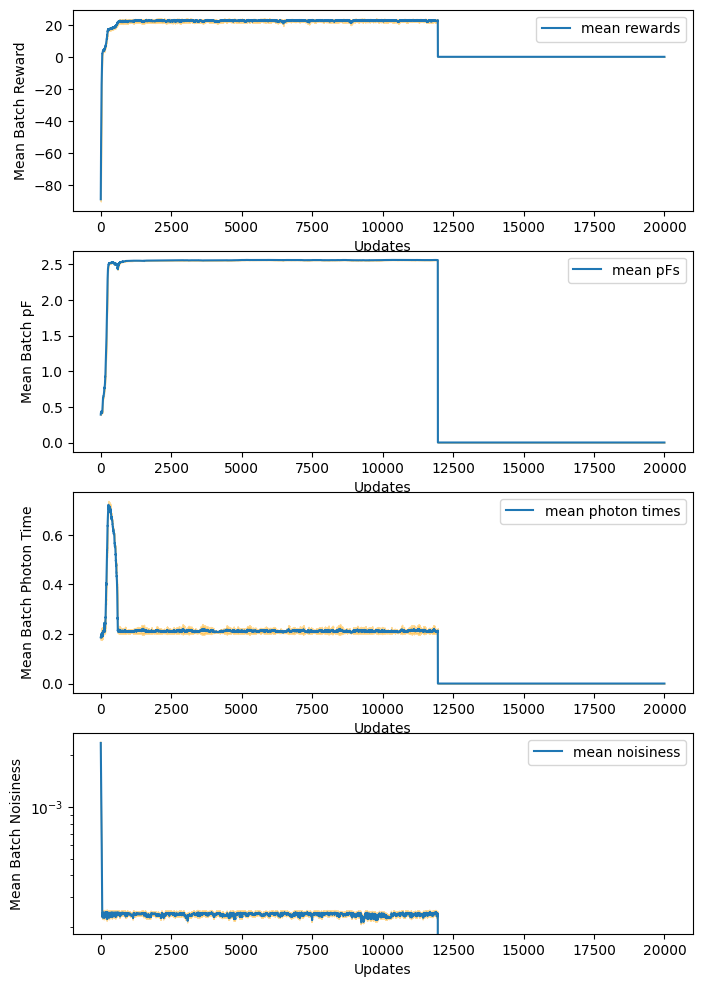

In [66]:
mean_rewards_sim = jnp.mean(sim_rewards_arr, axis=-1)
std_rewards_sim = jnp.std(sim_rewards_arr, axis=-1)

mean_pFs_sim = jnp.mean(sim_pF_arr, axis=-1)
std_pFs_sim = jnp.std(sim_pF_arr, axis=-1)

mean_times_sim = jnp.mean(sim_photon_time_arr, axis=-1)
std_times_sim = jnp.std(sim_photon_time_arr, axis=-1)

mean_smoothnesses_sim = jnp.mean(sim_smoothness_arr, axis=-1)
std_smoothnesses_sim = jnp.std(sim_smoothness_arr, axis=-1)

fig, ax = plt.subplots(4, figsize=(8.0, 12.0))

ax[0].plot(mean_rewards_sim, label='mean rewards')
ax[0].fill_between(jnp.arange(total_train_gens), mean_rewards_sim - std_rewards_sim, mean_rewards_sim + std_rewards_sim, color='orange', alpha=0.4)
ax[0].set_xlabel('Updates')
ax[0].set_ylabel('Mean Batch Reward')
ax[0].legend()

ax[1].plot(mean_pFs_sim, label='mean pFs')
ax[1].fill_between(jnp.arange(total_train_gens), mean_pFs_sim - std_pFs_sim, mean_pFs_sim + std_pFs_sim, color='orange', alpha=0.4)
ax[1].set_xlabel('Updates')
ax[1].set_ylabel('Mean Batch pF')
ax[1].legend()

ax[2].plot(mean_times_sim, label='mean photon times')
ax[2].fill_between(jnp.arange(total_train_gens), mean_times_sim - std_times_sim, mean_times_sim + std_times_sim, color='orange', alpha=0.4)
ax[2].set_xlabel('Updates')
ax[2].set_ylabel('Mean Batch Photon Time')
ax[2].legend()

ax[3].plot(mean_smoothnesses_sim, label='mean noisiness')
ax[3].fill_between(jnp.arange(total_train_gens), mean_smoothnesses_sim - std_smoothnesses_sim, mean_smoothnesses_sim + std_smoothnesses_sim, color='orange', alpha=0.4)
ax[3].set_xlabel('Updates')
ax[3].set_ylabel('Mean Batch Noisiness')
ax[3].set_yscale('log')
ax[3].legend()

plt.show()

## Testing out Differential Evolution

In [70]:
from evosax import DE

de_strategy = DE(popsize=num_envs, num_dims=env.num_actions)
de_params = de_strategy.default_params.replace(
    init_min=-1, 
    init_max=1,
    clip_min=-env.mu,
    clip_max=env.mu)
de_params

EvoParams(mutate_best_vector=True, num_diff_vectors=1, cross_over_rate=0.9, diff_w=0.8, init_min=-1, init_max=1, clip_min=-2.3255813953488373, clip_max=2.3255813953488373)

In [71]:
### Differential Evolution ###

rng = jax.random.PRNGKey(seed)

pso_name = 'DIFFERENTIAL_EVOLUTION'

# Make the Jax Random Seed in the Training Cell
# To ensure same seed is used for all runs
rng = jax.random.PRNGKey(seed=seed)
rng, _rng = jax.random.split(rng)

pso_state = de_strategy.initialize(_rng, de_params)

start = time.time()

# For Logging
print_rate = 100 # For monitoring the learning
total_train_gens = 5_000

def_reward = 100.
pso_fitness_arr = np.zeros(total_train_gens) - def_reward
pso_rewards_arr = np.zeros((total_train_gens, num_envs))
pso_smoothness_arr = np.zeros((total_train_gens, num_envs))
pso_photon_time_arr = np.zeros((total_train_gens, num_envs))
pso_pF_arr = np.zeros((total_train_gens, num_envs))
pso_actions_arr = np.zeros((total_train_gens, env.num_actions))

# Run ask-eval-tell loop - NOTE: By default minimization
for t in range(total_train_gens):
    rng, rng_gen = jax.random.split(rng, 2)
    x, pso_state = de_strategy.ask(rng_gen, pso_state, de_params) # Sampling actions from strategy
    fitness, env_state = vmap_rollout(x) # Function we defined
    pso_state = de_strategy.tell(x, fitness, pso_state, de_params) # Updating strategy with fitnesses

    # Logging
    pso_fitness_arr[t] = jnp.mean(fitness)
    pso_actions_arr[t] = jnp.mean(x, axis=0)

    pso_rewards_arr[t] = env_state[:,0]
    pso_pF_arr[t] = env_state[:,1]
    pso_photon_time_arr[t] = env_state[:,3]
    pso_smoothness_arr[t] = env_state[:,4]

    if (t + 1) % print_rate == 0:
        print(f"{pso_name} - # Gen: {t + 1}|Fitness: {pso_state.best_fitness}")
        print(f"Reward: {jnp.round(jnp.mean(pso_rewards_arr[t]), 2)} ± {jnp.round(jnp.std(pso_rewards_arr[t]), 2)}")
        print(f"pF: {jnp.round(jnp.mean(pso_pF_arr[t]), 3)} ± {jnp.round(jnp.std(pso_pF_arr[t]), 3)}")
        print(f"Photon Time: {jnp.round(jnp.mean(pso_photon_time_arr[t]), 4)} ± {jnp.round(jnp.std(pso_photon_time_arr[t]), 4)}")
        print(f"Smoothness: {jnp.round(jnp.mean(pso_smoothness_arr[t]), 6)} ± {jnp.round(jnp.std(pso_smoothness_arr[t]), 6)}")
        print(f"Time: {time.time() - start}")

DIFFERENTIAL_EVOLUTION - # Gen: 100|Fitness: 35.23525619506836
Reward: -237.74 ± 97.66
pF: 0.631 ± 0.233
Photon Time: 0.2142 ± 0.1391
Smoothness: 0.004555 ± 0.000913
Time: 38.7276771068573
DIFFERENTIAL_EVOLUTION - # Gen: 200|Fitness: 24.456819534301758
Reward: -173.34 ± 92.53
pF: 0.622 ± 0.231
Photon Time: 0.2177 ± 0.1476
Smoothness: 0.003074 ± 0.0006659999999999999
Time: 69.34600901603699
DIFFERENTIAL_EVOLUTION - # Gen: 300|Fitness: 23.45890235900879
Reward: -135.04 ± 85.63
pF: 0.542 ± 0.17500000000000002
Photon Time: 0.18810000000000002 ± 0.11800000000000001
Smoothness: 0.002395 ± 0.000536
Time: 98.63756203651428
DIFFERENTIAL_EVOLUTION - # Gen: 400|Fitness: 15.324193000793457
Reward: -117.64 ± 84.91
pF: 0.595 ± 0.20400000000000001
Photon Time: 0.19190000000000002 ± 0.1032
Smoothness: 0.001972 ± 0.000387
Time: 125.97517895698547
DIFFERENTIAL_EVOLUTION - # Gen: 500|Fitness: 14.234758377075195
Reward: -92.74 ± 78.23
pF: 0.5750000000000001 ± 0.20400000000000001
Photon Time: 0.1932 ± 0.09

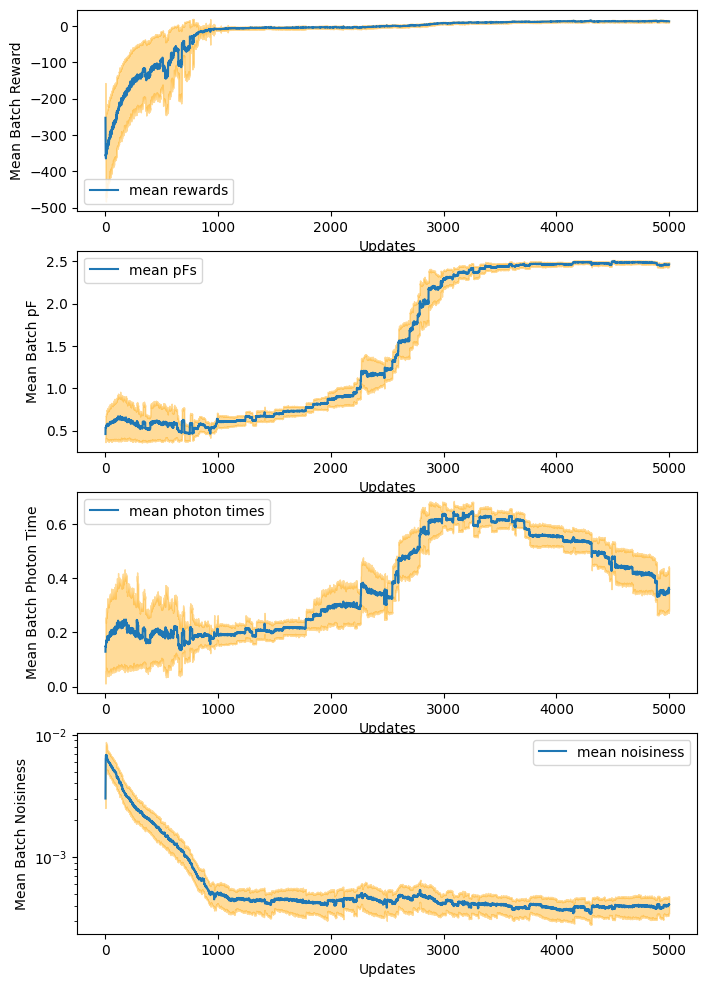

In [72]:
mean_rewards_pso = jnp.mean(pso_rewards_arr, axis=-1)
std_rewards_pso = jnp.std(pso_rewards_arr, axis=-1)

mean_pFs_pso = jnp.mean(pso_pF_arr, axis=-1)
std_pFs_pso = jnp.std(pso_pF_arr, axis=-1)

mean_times_pso = jnp.mean(pso_photon_time_arr, axis=-1)
std_times_pso = jnp.std(pso_photon_time_arr, axis=-1)

mean_smoothnesses_pso = jnp.mean(pso_smoothness_arr, axis=-1)
std_smoothnesses_pso = jnp.std(pso_smoothness_arr, axis=-1)

fig, ax = plt.subplots(4, figsize=(8.0, 12.0))

ax[0].plot(mean_rewards_pso, label='mean rewards')
ax[0].fill_between(jnp.arange(total_train_gens), mean_rewards_pso - std_rewards_pso, mean_rewards_pso + std_rewards_pso, color='orange', alpha=0.4)
ax[0].set_xlabel('Updates')
ax[0].set_ylabel('Mean Batch Reward')
ax[0].legend()

ax[1].plot(mean_pFs_pso, label='mean pFs')
ax[1].fill_between(jnp.arange(total_train_gens), mean_pFs_pso - std_pFs_pso, mean_pFs_pso + std_pFs_pso, color='orange', alpha=0.4)
ax[1].set_xlabel('Updates')
ax[1].set_ylabel('Mean Batch pF')
ax[1].legend()

ax[2].plot(mean_times_pso, label='mean photon times')
ax[2].fill_between(jnp.arange(total_train_gens), mean_times_pso - std_times_pso, mean_times_pso + std_times_pso, color='orange', alpha=0.4)
ax[2].set_xlabel('Updates')
ax[2].set_ylabel('Mean Batch Photon Time')
ax[2].legend()

ax[3].plot(mean_smoothnesses_pso, label='mean noisiness')
ax[3].fill_between(jnp.arange(total_train_gens), mean_smoothnesses_pso - std_smoothnesses_pso, mean_smoothnesses_pso + std_smoothnesses_pso, color='orange', alpha=0.4)
ax[3].set_xlabel('Updates')
ax[3].set_ylabel('Mean Batch Noisiness')
ax[3].set_yscale('log')
ax[3].legend()

plt.show()

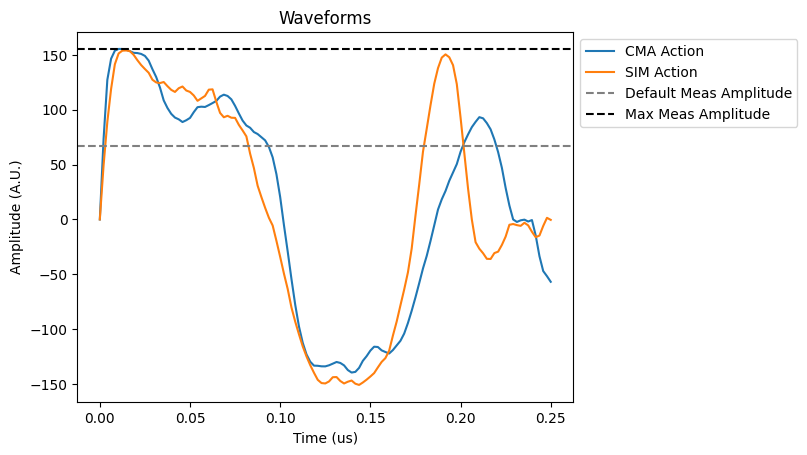

In [61]:
raw_cma_action = -cma_state.best_member
opt_cma_action = env.prepare_action(raw_cma_action)

raw_sim_action = sim_state.best_member
opt_sim_action = env.prepare_action(raw_sim_action)

plt.plot(env.ts_action, opt_cma_action, label='CMA Action')
plt.plot(env.ts_action, opt_sim_action, label='SIM Action')
plt.axhline(y=env.a0, label='Default Meas Amplitude', linestyle='dashed', color='grey')
plt.axhline(y=env.a0 * env.mu, label='Max Meas Amplitude', linestyle='dashed', color='black')
plt.legend(bbox_to_anchor=(1., 1.))
plt.xlabel('Time (us)')
plt.ylabel('Amplitude (A.U.)')
plt.title('Waveforms')
plt.show()

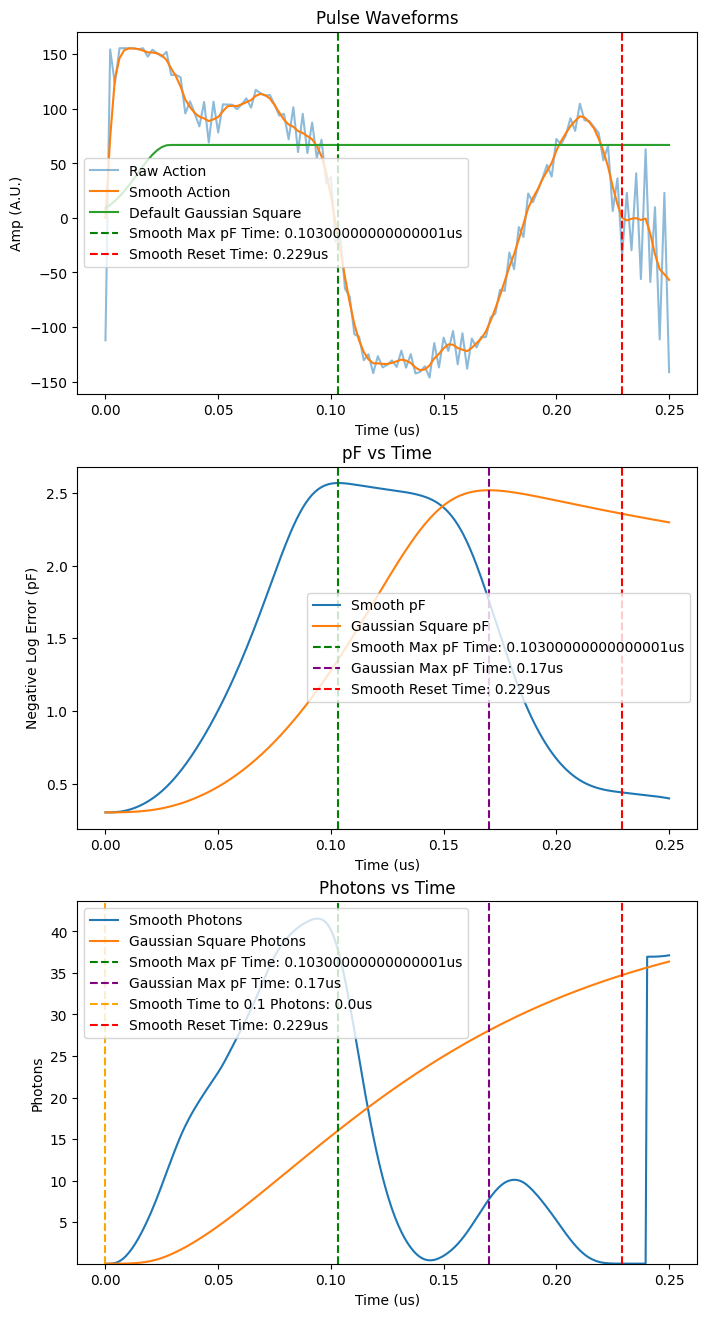

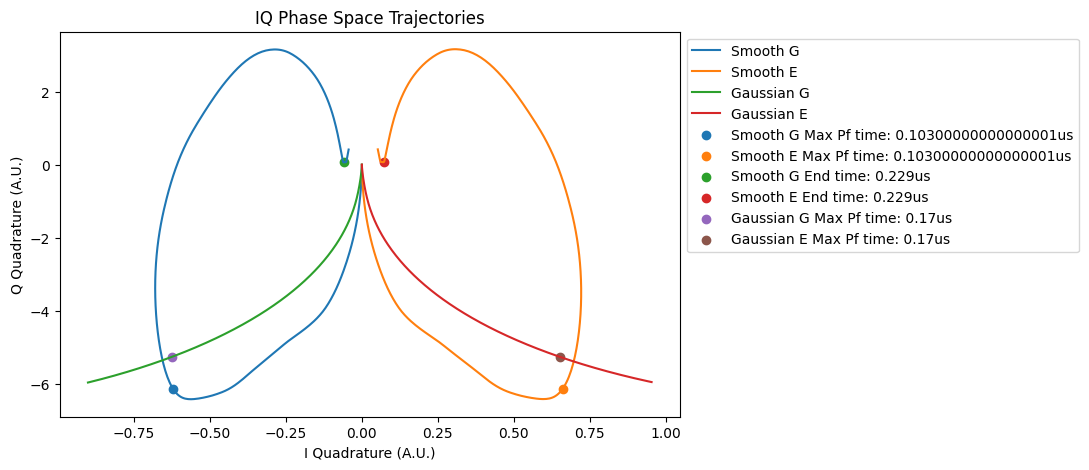

In [32]:
env.rollout_action(raw_cma_action)

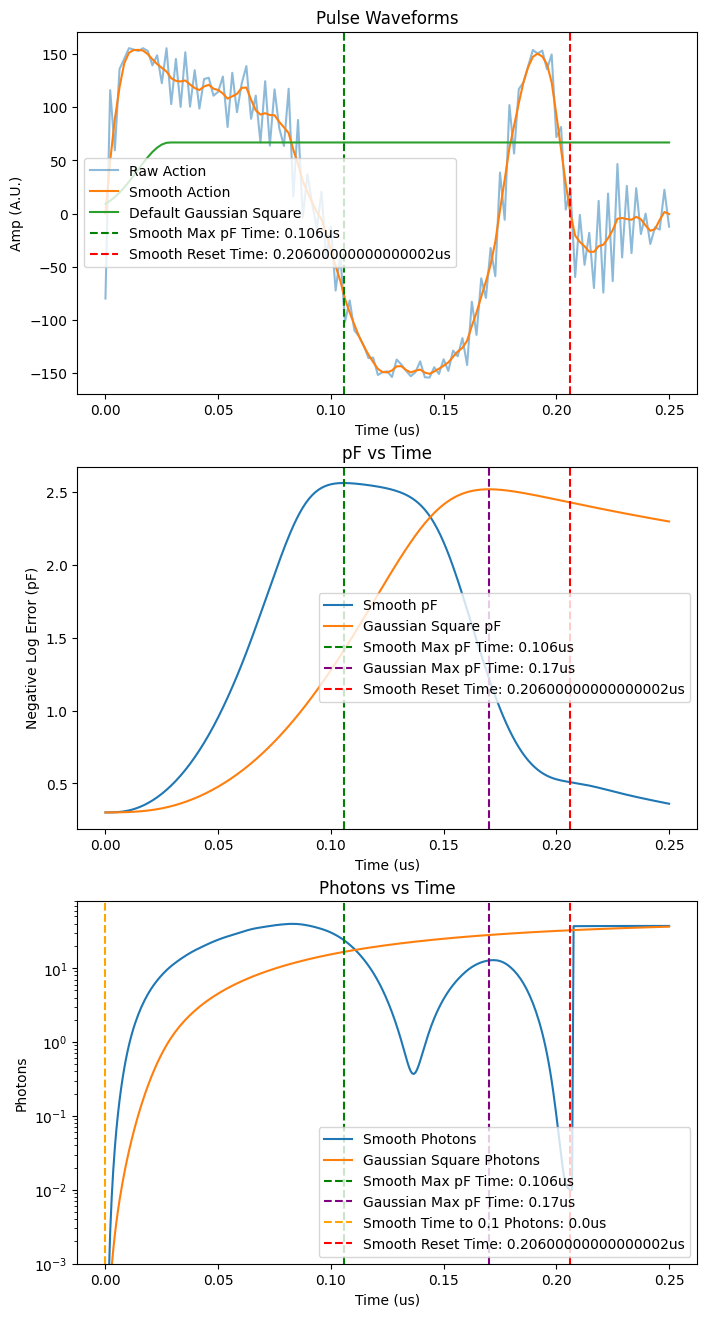

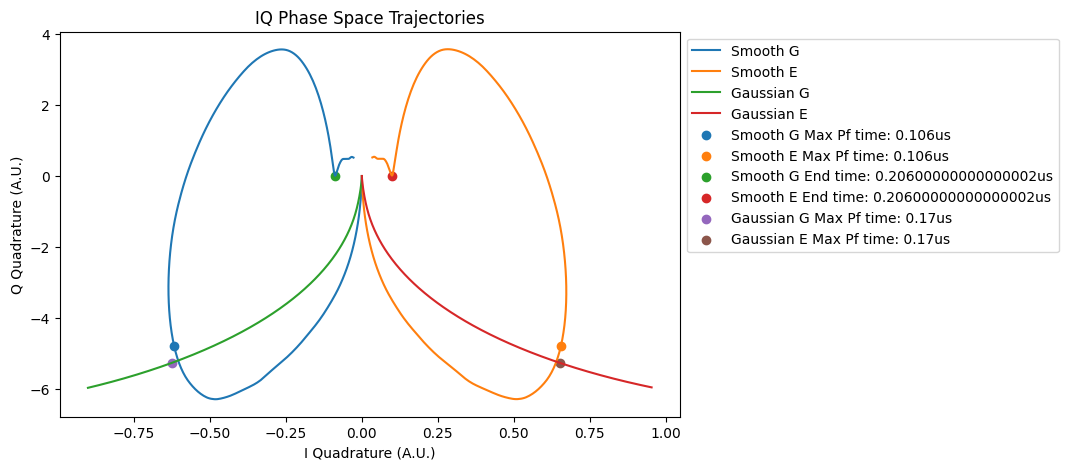

In [64]:
env.rollout_action(raw_sim_action, photon_log_scale=True)